In [ ]:
#!pip install torchaudio
# https://github.com/markovka17/dla/blob/2021/week08/seminar08.ipynb
#https://www.youtube.com/watch?app=desktop&v=-KDSqVPlx3s

In [ ]:
import math
import pathlib
import random
import itertools
from tqdm import tqdm

from IPython import display
from dataclasses import dataclass

import torch
import torch.nn.functional as F
from torch import distributions
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader

import torchaudio
from torchaudio.transforms import MelSpectrogram

import librosa
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

In [ ]:
torch.__version__

'1.10.0+cu111'

Causal Convolution Block

We use nn.ConstantPad1d to add zeros from the left. How to calculate the size of the padding? If the kernal size is M and the length of the input L, then output has length L-M+1. If we want to have the same length, we should add M-1 zeros (then L+M-1 -M+1 = L).

For example, create a tensor:

```
batch_size = 1
in_channel = 1
time =10
inp = torch.arange(time).reshape(batch_size, in_channel, time).float()
#inp = torch.rand(batch_size, in_channel, time)
inp
```
tensor([[[0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]]])

Create a kernal:
```
kernel_size = 2
padding_f = nn.ConstantPad1d((kernel_size-1,0), value=0.0)
conv = nn.Conv1d(1,1,kernel_size,bias=False,dilation=1)
conv.weight.data = torch.ones(1,1,kernel_size)
conv.weight.data
```
tensor([[[1., 1.]]])
```
print(padding_f(inp))
print(conv(padding_f(inp)))
```
tensor([[[0., 0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]]])

tensor([[[ 0.,  1.,  3.,  5.,  7.,  9., 11., 13., 15., 17.]]],
       grad_fn=\<SqueezeBackward1\>)

As a result, two nearest digits were addad with weights 1 and the length of the output did not change.

If we want to add a dilation (dilatation) D, then we should add (M-1)*d zeros.

In [ ]:
batch_size = 1
in_channel = 1
time =10
inp = torch.arange(time).reshape(batch_size, in_channel, time).float()
# inp = torch.rand(batch_size, in_channel, time)
print(f'Input: {inp}')

Input: tensor([[[0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]]])


In [ ]:
kernel_size = 3
padding_f = nn.ConstantPad1d(((kernel_size-1)*2,0), value=0.0) #Padding size from the left and from the right
print(f'After padding: {padding_f(inp)}')

After padding: tensor([[[0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]]])


In [ ]:
conv = nn.Conv1d(1,1,kernel_size,bias=False,dilation=2)
conv.weight.data = torch.ones(1,1,kernel_size)
conv.weight.data[0][0][-1] = -1
print(f'Convolition filter: {conv.weight.data}')

Convolition filter: tensor([[[ 1.,  1., -1.]]])


In [ ]:
print(f'Output: {conv(padding_f(inp))}')

Output: tensor([[[ 0., -1., -2., -2., -2., -1.,  0.,  1.,  2.,  3.]]],
       grad_fn=<SqueezeBackward1>)


In [ ]:
class CausalConv1d(nn.Conv1d):
    """
    Casual Conv1d
    """

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: int,
        dilation: int = 1,
        bias: bool = True
    ):
        super().__init__(
            in_channels,
            out_channels,
            kernel_size,
            dilation=dilation,
            bias=bias
        )
        # Add zero padding from the left to get the output of the same lenght as input:
        padding_size = (kernel_size - 1) * dilation
        self.zero_padding = nn.ConstantPad1d(
            padding=(padding_size, 0),
            value=0.0
        )

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        padded_input = self.zero_padding(input)
        output = super().forward(padded_input)
        return output

### Gated Activation Unit
$tanh(W_f*x )\cdot \sigma(W_g*x)$

filter and gate convolutions, where $W_f$ and $W_g$ are the weights from Casual_Conv1d. Therefore, the output has the same size as the input.

In [ ]:
class GatedConv1d(nn.Module):
    """
    Gated Conv1d
    """

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: int,
        dilation: int
    ):
        super().__init__()

        self.filter_conv = CausalConv1d(in_channels, out_channels, kernel_size, dilation)
        self.gate_conv = CausalConv1d(in_channels, out_channels, kernel_size, dilation)

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        filter_ouput = self.filter_conv(input)
        gate_output = self.gate_conv(input)

        output = torch.tanh(filter_ouput) * torch.sigmoid(gate_output)

        return output

Conditioned GAU $tanh(W_f*x + V_f*x_c)\cdot \sigma(W_g*x+V_g*x_c)$

In [ ]:
class CondGatedConv1d(GatedConv1d):
    """
    Conditioned Gated Conv1d
    """

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        cond_in_channels: int,
        kernel_size: int,
        dilation: int
    ):
        super().__init__(in_channels, out_channels, kernel_size, dilation)

        self.cond_conv = nn.Conv1d(
            in_channels=cond_in_channels,
            out_channels=2 * out_channels,
            kernel_size=1
        )

    def forward(
        self,
        input: torch.Tensor,
        condition: torch.Tensor
    ) -> torch.Tensor:
        assert input.size(-1) == condition.size(-1)

        filter_ouput = self.filter_conv(input)
        gate_output = self.gate_conv(input)

        c_output = self.cond_conv(condition)
        # We can use  2 channels instead of two filters (function chunk):
        c_filter_output, c_gate_output = torch.chunk(c_output, 2, dim=1)

        output = torch.tanh(filter_ouput + c_filter_output) * torch.sigmoid(gate_output + c_gate_output)

        return output

Example of using chunk
```
torch.chunk(inp, 2, dim=-1)
```
(tensor([[[0., 1., 2., 3., 4.]]]), tensor([[[5., 6., 7., 8., 9.]]]))

In [ ]:
torch.chunk(inp, 2, dim=-1)

(tensor([[[0., 1., 2., 3., 4.]]]), tensor([[[5., 6., 7., 8., 9.]]]))

### Residual Block

In [ ]:
class CondWaveNetBlock(nn.Module):
    """
    Conditioned WaveNet block
    """

    def __init__(
        self,
        gated_in_channels: int,
        gated_out_channels: int,
        cond_in_channels: int,
        skip_out_channels: int,
        kernel_size: int,
        dilation: int
    ):
        super().__init__()

        self.gated_cond = CondGatedConv1d(
            in_channels=gated_in_channels,
            out_channels=gated_out_channels,
            cond_in_channels=cond_in_channels,
            kernel_size=kernel_size,
            dilation=dilation
        )

        self.skip_conv = nn.Conv1d(gated_out_channels, skip_out_channels, kernel_size=1)
        self.residual_conv = nn.Conv1d(gated_out_channels, gated_in_channels, kernel_size=1)


    def forward(self, input: torch.Tensor, condition: torch.Tensor) -> torch.Tensor:
        gated_output = self.gated_cond(input, condition)

        # y = f(x) + x
        residual_output = self.residual_conv(gated_output) + input
        skip_output = self.skip_conv(gated_output)

        return residual_output, skip_output

### Reduce quantisation size from $2^{16}$ to $2^8$
$f(x) = sign(x) \dfrac{\ln(1+\mu |x|)}{\ln(1+\mu)}$

In [ ]:
class MuLaw(nn.Module):

    def __init__(self, mu: float = 256):
        super().__init__()
        self.register_buffer('mu', torch.FloatTensor([mu - 1]))

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        return self.encode(input)

    def encode(self, input: torch.Tensor) -> torch.Tensor:
        input = torch.clamp(input, -1 + 1e-5, 1 - 1e-5)

        mu_law_output = torch.sign(input) * torch.log1p(self.mu * torch.abs(input)) / torch.log1p(self.mu)

        # [-1, 1] -> [0, 1]
        quantized_output = (mu_law_output + 1) / 2

        # [0, 1] -> [0, mu - 1]
        quantized_output = torch.floor(quantized_output * self.mu + 0.5).long()

        return quantized_output

    def decode(self, input: torch.Tensor) -> torch.Tensor:
        dequantized_output = (input.float() / self.mu) * 2 - 1
        output = (torch.sign(dequantized_output) / self.mu) * \
            ((1 + self.mu) ** torch.abs(dequantized_output) - 1)

        return output

```
mu_law_encoder = MuLaw(256)
input = torch.randn(5).mul(0.1).clamp(-1, 1)
print(f'Input: {input}')
print(f'After MuLaw Encoding: {mu_law_encoder(input)}')
print(f'After MuLaw Decoding: {mu_law_encoder.decode(mu_law_encoder(input))}')

Input: tensor([ 0.1020, -0.0206, -0.0404,  0.0036,  0.2439])

After MuLaw Encoding: tensor([203,  85,  72, 142, 223])

After MuLaw Decoding: tensor([ 0.1007, -0.0210, -0.0399,  0.0034,  0.2457])
```

In [ ]:
class OneHot(nn.Module):
    """
    Convert quantized 1d samples into n_class one-hot tensor
    """

    def __init__(self, n_class: int = 256):
        super().__init__()

        self.n_class = n_class

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        assert input.dim() == 3, "Expected shape of input is [B, C, T], where C == 1"
        return self.encode(input)

    def encode(self, input: torch.Tensor) -> torch.Tensor:
        output = torch.zeros(input.size(0), self.n_class, input.size(-1), device=input.device)
        output.scatter_(1, input, 1)
        return output

    def decode(self, input: torch.Tensor) -> torch.Tensor:
        raise NotImplementedError()

```
upsampling = nn.Upsample(scale_factor=3, mode='nearest')
input = torch.arange(5).view(1, 1, -1).float()
print(f'Input: {input.squeeze()}')
print(f'After Upsampling: {upsampling(input).squeeze()}')

Input: tensor([0., 1., 2., 3., 4.])
After Upsampling: tensor([0., 0., 0., 1., 1., 1., 2., 2., 2., 3., 3., 3., 4., 4., 4.])
```

In [ ]:
class CondNet(nn.Module):
    """
    Processing condition (mel from TTS or something else)
    """

    def __init__(self, input_size: int, hidden_size: int, hop_size: int):
        """
        :param input_size:
        """
        super().__init__()

        self.input_size = input_size
        self.hop_size = hop_size
        self.hidden_size = hidden_size

        self.net = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size // 2,
            num_layers=2,
            batch_first=True,
            bidirectional=True,
        )
        self.upsampler = nn.Upsample(scale_factor=hop_size, mode='nearest')

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        """
        :return: .shape == [B, T', C']
        """

        assert input.shape[-1] == self.input_size

        self.net.flatten_parameters()

        output, _ = self.net(input)

        output = output.transpose(-1, -2)
        upsampled_output = self.upsampler(output)

        return upsampled_output

WaveNet

In [ ]:
class WaveNet(nn.Module):

    def __init__(
        self,
        # in_channels: int = 256,
        # out_channels: int = 256,
        # gate_channels: int = 512,
        # residual_channels: int = 256,
        # skip_channels: int = 256,
        # head_channels: int = 256,
        # condition_channels: int = 256,

        in_channels: int = 64,
        out_channels: int = 64,
        gate_channels: int = 64,
        residual_channels: int = 64,
        skip_channels: int = 64,
        head_channels: int = 64,
        condition_channels: int = 64,
        kernel_size: int = 2,
        dilation_cycles: int = 3,
        dilation_depth: int = 10,
        upsample_factor: int = 480,
    ) -> None:
        super().__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.gate_channels = gate_channels
        self.residual_channels = residual_channels
        self.skip_channels = skip_channels
        self.head_channels = head_channels
        self.condition_channels = condition_channels
        self.kernel_size = kernel_size
        self.dilation_cycles = dilation_cycles
        self.dilation_depth = dilation_depth
        self.upsample_factor = upsample_factor

        # 80 -- number of channels in mels
        self.cond = CondNet(80, self.condition_channels, upsample_factor)

        self.stem = nn.Sequential(
            nn.Conv1d(in_channels, residual_channels, kernel_size=1)
        )

        self.blocks = nn.ModuleList([
            CondWaveNetBlock(residual_channels, gate_channels, condition_channels, skip_channels,
                             kernel_size, 2 ** (i % dilation_depth))
            for i in range(dilation_cycles * dilation_depth)
        ])

        # To avoid DDP error
        self.blocks[-1].residual_conv.requires_grad_(False)

        self.head = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Conv1d(skip_channels, head_channels, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv1d(head_channels, out_channels, kernel_size=1),
        )

    def _forward(self, input: torch.Tensor, condition: torch.Tensor) -> torch.Tensor:
        # already upsampled condition

        stem_output = self.stem(input)

        accumulation = 0
        residual_output = stem_output
        for i, block in enumerate(self.blocks):
            residual_output, skip_output = block(residual_output, condition)
            accumulation = accumulation + skip_output

        output = self.head(accumulation)

        return output

    def forward(self, input: torch.Tensor, condition: torch.Tensor) -> torch.Tensor:
        """
        :param input: samples
        :param condition: mel
        """

        condition = self.cond(condition)
        output = self._forward(input, condition)

        return output

    @property
    def num_parameters(self) -> int:
        return sum([p.numel() for p in self.parameters()])

    @property
    def receptive_field(self) -> int:
        dilations = [2 ** (i % self.dilation_depth)
                     for i in range(self.dilation_cycles * self.dilation_depth)]
        receptive_field = (self.kernel_size - 1) * sum(dilations) + 1

        return receptive_field

    def generate(self, condition: torch.Tensor, inference_type: str = "naive", verbose: bool = True) -> torch.Tensor:
        """
        :param condition: [1, T, C], C from ASR
        :param inference_type:
        :param verbose:
        """

        mu_low = MuLaw().to(condition.device)

        if inference_type == "naive":
            compressed_samples = self._naive_generate(condition, verbose)
        elif inference_type == "fast":
            compressed_samples = self._fast_generate(condition)
        else:
            raise ValueError(f"Invalid type of inference: {inference_type}")

        return mu_low.decode(compressed_samples)

    @torch.no_grad()
    def _naive_generate(self, condition: torch.Tensor, verbose: bool) -> torch.Tensor:
        one_hot = OneHot()

        required_num_samples = condition.shape[1] * self.upsample_factor
        generated_samples = torch.Tensor(1, 1, self.receptive_field + required_num_samples) \
            .fill_(self.in_channels // 2) \
            .to(condition.device)

        condition = self.cond(condition)
        condition = F.pad(condition, (self.receptive_field, 0), 'replicate')

        iterator = range(required_num_samples)
        if verbose:
            iterator = tqdm(iterator)

        for i in iterator:
            current_condition = condition[:, :, i:i + self.receptive_field]
            current_samples = generated_samples[:, :, i:i + self.receptive_field]
            current_one_hot_samples = one_hot(current_samples.long())

            current_output = self._forward(current_one_hot_samples, current_condition)
            last_logits = current_output[:, :, -1].squeeze()

            # sampling new sample
            samples = distributions.Categorical(logits=last_logits)
            new_sample = samples.sample(torch.Size([1]))
            generated_samples[:, :, i + self.receptive_field] = new_sample

        return generated_samples.squeeze()[-required_num_samples:]

In [ ]:
model = WaveNet()

In [ ]:
@dataclass
class MelSpectrogramConfig:
  sr: int = 22050
  win_length: int = 1024
  hop_length: int = 256
  n_fft: int = 1024
  f_min: int = 0
  f_max: int = 8000
  n_mels: int = 80
  power: float = 1.0

  pad_value: float = -11.5129251

class MelSpectrogram(nn.Module):

  def __init__(self, config: MelSpectrogramConfig):
    super(MelSpectrogram, self).__init__()
    self.config = config
    self.mel_spectrogram = torchaudio.transforms.MelSpectrogram(
        sample_rate=config.sr,
        win_length=config.win_length,
        hop_length=config.hop_length,
        n_fft=config.n_fft,
        f_min=config.f_min,
        f_max=config.f_max,
        n_mels=config.n_mels
    )
    self.mel_spectrogram.spectrogram.power=config.power

    mel_basis = librosa.filters.mel(
        sr=config.sr,
        n_fft=config.n_fft,
        n_mels=config.n_mels,
        fmin=config.f_min,
        fmax=config.f_max
    ).T
    self.mel_spectrogram.mel_scale.fb.copy_(torch.tensor(mel_basis))

  def forward(self, audio: torch.Tensor) -> torch.Tensor:
    mel = self.mel_spectrogram(audio).clamp_(min=1e-5).log_()
    return mel

In [ ]:
#wav, sr = torchaudio.load('1. No. 1 in C major.wav')

In [ ]:
mel_spec = MelSpectrogram(MelSpectrogramConfig())

In [ ]:
# It took 6-7 minutes on Colab
!wget https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2
!tar -xf LJSpeech-1.1.tar.bz2

--2022-02-10 19:56:48--  https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2
Resolving data.keithito.com (data.keithito.com)... 174.138.79.61
Connecting to data.keithito.com (data.keithito.com)|174.138.79.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2748572632 (2.6G) [application/octet-stream]
Saving to: ‘LJSpeech-1.1.tar.bz2’

LJSpeech-1.1.tar.bz 100%[===================>]   2.56G  47.8MB/s    in 58s     

2022-02-10 19:57:46 (45.0 MB/s) - ‘LJSpeech-1.1.tar.bz2’ saved [2748572632/2748572632]



In [ ]:
wav, sr = torchaudio.load('./LJSpeech-1.1/wavs/LJ001-0001.wav')
spec = mel_spec(wav)

In [ ]:
spec.shape

torch.Size([1, 80, 832])

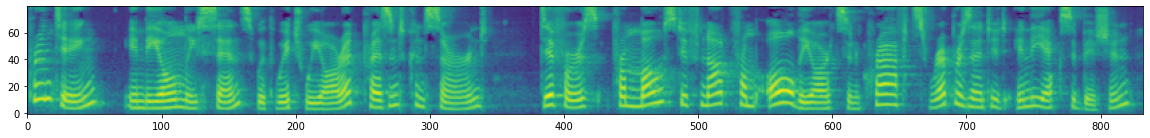

In [ ]:
plt.figure(figsize=(20,5))
plt.imshow(spec.squeeze(), origin='lower')

In [ ]:
# w = wav[0].unsqueeze(dim=0)
# mu = MuLaw(64)
# one_hot = OneHot(64)
# w1 = one_hot(mu(w.unsqueeze(dim=0))) #.unsqueeze(dim=1)

In [ ]:
class LJSpeech(Dataset):
    def __init__(
        self,
        path2csv: str,
        mel_spec_config: MelSpectrogramConfig,
        dataset_root: str = './LJSpeech-1.1',
        max_time_samples: int = 256 * 76,
        train: bool = True
    ):
        super().__init__()
        self.path2csv = path2csv
        self.mel_spec_config = mel_spec_config
        self.dataset_root = pathlib.Path(dataset_root)
        self.max_time_samples = max_time_samples
        self.train = train

        self.featurizer = MelSpectrogram(mel_spec_config)

        df = pd.read_csv(
            path2csv,
            names=['id', 'gt', 'gt_letters_only'],
            sep="|"
        )
        df = df.dropna()

        self.names = list(df['id'])

    def __len__(self):
        return len(self.names)

    def __getitem__(self, idx):
        wav, sr = torchaudio.load(self.dataset_root / f'wavs/{self.names[idx]}.wav')
        wav.squeeze_()

        if self.train:
            # crop wav to `self.sample_per_wav` size
            start_sample = random.randint(0, wav.size(-1) - self.max_time_samples)
            wav = wav[start_sample:start_sample + self.max_time_samples]

        return wav

In [ ]:
train_dataset = LJSpeech(
    '/content/LJSpeech-1.1/metadata.csv',
    MelSpectrogramConfig(),
    max_time_samples=256*76,
)
train_dataloader = DataLoader(train_dataset, batch_size=2, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
class AverageMeter:

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
# just to know
BATCH, CHANNEL, TIME = 0, 1, 2

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = WaveNet(
    in_channels=256,
    out_channels=256,
    condition_channels=80,
    upsample_factor=256
).to(device)

mu_law = MuLaw(256).to(device)
one_hot = OneHot(256).to(device)
mel_specer = MelSpectrogram(MelSpectrogramConfig()).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss().to(device)

In [ ]:
train_loss = []

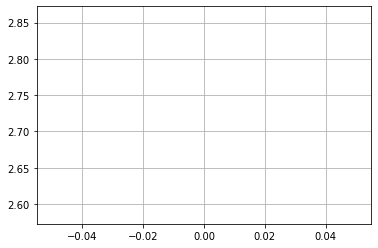

In [ ]:
num_epoch = 1

for epoch in range(num_epoch):

    train_epoch_loss = AverageMeter()

    model.train()
    for i, samples in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        # global_step = epoch * len(train_dataloader) + i
        optimizer.zero_grad()

        samples = samples.to(device)
        # crop mels since mel_specer produce reduntant padding
        mels = mel_specer(samples)[..., :-1]

        categorical_samples = mu_law(samples).unsqueeze(dim=1)
        one_hot_samples = one_hot(categorical_samples)
        prediction = model(one_hot_samples, mels.transpose(-1, -2))

        loss = criterion(prediction[:, :, :-1],
                         categorical_samples.squeeze(dim=1)[:, 1:])
        loss.backward()

        optimizer.step()

        # Print loss
        if i % 50 == 0:
            train_epoch_loss.update(loss.item())
            print("Loss: ", loss.item())

    train_loss.append(train_epoch_loss.avg)

    display.clear_output()
    plt.plot(train_loss)
    plt.grid()
    plt.show()

In [ ]:
# Yes, it is the same dataset but it does not matter now
validation_dataset = LJSpeech(
    '/content/LJSpeech-1.1/metadata.csv',
    MelSpectrogramConfig(),
    max_time_samples=256 * 76,
    train=False
)
val_wav = validation_dataset[0]
val_mel = mel_spec(val_wav[:10000])
# 160 mels ~= 2 sec
#generated_val_wav = model.generate(val_mel[..., :15].unsqueeze(0).transpose(-1, -2).to(device))
generated_val_wav = model.generate(val_mel.unsqueeze(0).transpose(-1, -2).to(device))

100%|██████████| 10240/10240 [03:36<00:00, 47.33it/s]


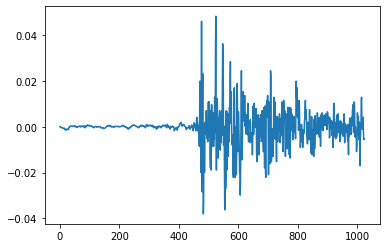

In [ ]:
plt.plot(generated_val_wav.cpu())

In [ ]:
display.Audio(generated_val_wav.cpu(), rate=22050)

In [ ]:
display.Audio(val_wav[:10000], rate=22050)